## Estimating the number of Kalman stars

The star residuals from the PCAD centroids and quaternions are available for all observations (with known star catalogs) and star slots.  The following work shows that the calculated star residuals are "just as good" as some available onboard measurement residuals for use in independently determining the number of stars available to the Kalman filter.

In [74]:
import numpy as np
from astropy.table import Table
import mica.quaternion
from Ska.quatutil import radec2eci
import agasc
from kadi import events
from Ska.engarchive import fetch
from Ska.Matplotlib import plot_cxctime
from Ska.Numpy import smooth
import mica.starcheck
from Chandra.Time import DateTime

In [75]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [76]:
msids = ['AOACASEQ', 'AOPCADMD', 'AOKALSTR',  'COTLRDSF', 'COBSRQID',
        'AOATTQT1', 'AOATTQT2', 'AOATTQT3', 'AOATTQT4']
res_msids = ['AORESY0','AORESY1_1', 'AORESY2_1', 'AORESY3', 'AORESY4',
         'AORESY5_1','AORESY6_1', 'AORESY7', 'AORESZ0', 'AORESZ1_1',
         'AORESZ2_1','AORESZ3', 'AORESZ4', 'AORESZ5_1', 'AORESZ6_1',
         'AORESZ7']
slot_cols = ['AOACFID', 'AOACMAG', 'AOACYAN', 'AOACZAN', 'AOACFCT', 'AOIMAGE',
             'AOACIDP', 'AOACIIR', 'AOACIMS', 'AOACISP']
slots = range(0, 8)
slot_msids = ["{}{}".format(field, slot) for field in slot_cols
                  for slot in slots]

Obsid 19697 is an observation that has a slot that shows a period with large onboard measurement residuals.  As expected, during this period, the AOKALSTR count shows a value that never reaches 5 stars.

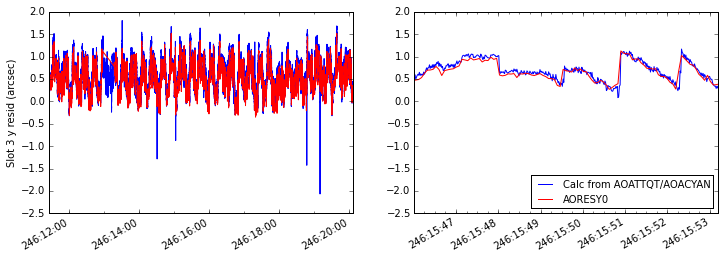

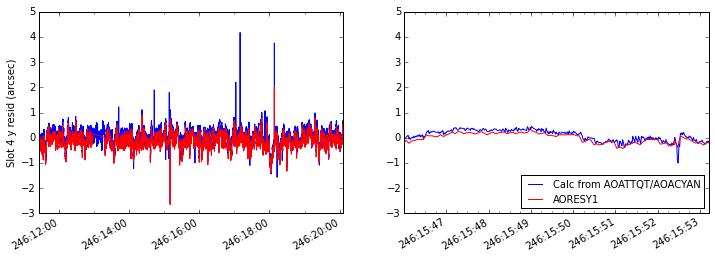

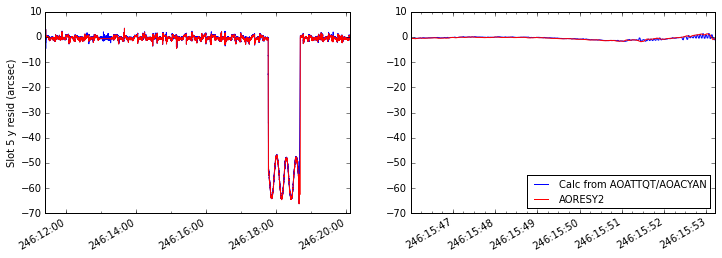

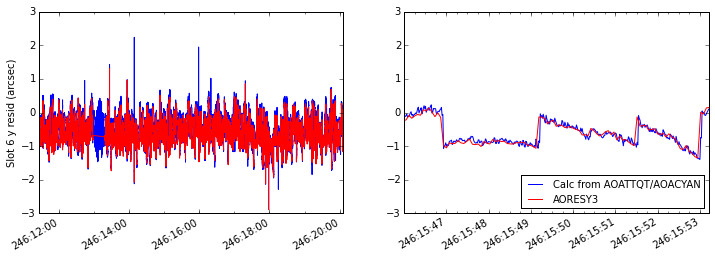

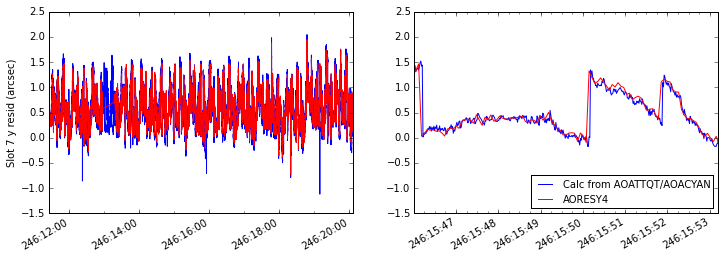

In [77]:
obsid = 19697
sc = mica.starcheck.get_starcheck_catalog(obsid)
catalog = Table(sc['cat'])
obs_dwells = events.dwells.filter(obsid=obsid)
d = obs_dwells[0]
if d.start < '2015:251':
    pcad_data = fetch.Msidset(msids + res_msids + slot_msids, d.start, d.stop)
else:
    pcad_data = fetch.Msidset(msids + res_msids + slot_msids + ['AOACIMSS'], d.start, d.stop)
# copy these to better names                                                                                            
for slot in [1, 2, 5, 6]:
    pcad_data['AORESY{}'.format(slot)] = pcad_data['AORESY{}_1'.format(slot)]
    pcad_data['AORESZ{}'.format(slot)] = pcad_data['AORESZ{}_1'.format(slot)]
q_atts = mica.quaternion.Quat(mica.quaternion.normalize(np.column_stack([pcad_data['AOATTQT1'].vals,
                                        pcad_data['AOATTQT2'].vals,
                                        pcad_data['AOATTQT3'].vals,
                                        pcad_data['AOATTQT4'].vals])))
expected_pos = {}
resids = {}
yag_offs = np.zeros((len(pcad_data['AOKALSTR'].vals), 8))
zag_offs = np.zeros((len(pcad_data['AOKALSTR'].vals), 8))
for entry in catalog[(catalog['type'] == 'BOT') | (catalog['type'] == 'GUI')]:
    slot = entry['slot']
    star = agasc.get_star(entry['id'], date=d.manvr.start)
    eci = radec2eci(star['RA_PMCORR'], star['DEC_PMCORR'])
    d_aca = np.dot(q_atts.transform.transpose(0,2,1), eci)
    yag = np.degrees(np.arctan2(d_aca[:, 1], d_aca[:, 0])) * 3600
    zag = np.degrees(np.arctan2(d_aca[:, 2], d_aca[:, 0])) * 3600
    yag_offs[:, slot] = yag - pcad_data['AOACYAN{}'.format(entry['slot'])].vals
    zag_offs[:, slot] = zag - pcad_data['AOACZAN{}'.format(entry['slot'])].vals
    expected_pos[slot] = {'yag': yag, 'zag': zag}
pd = pcad_data
# these slots should work for most ORs
for slot, pos in zip([3, 4, 5, 6, 7],[0, 1, 2, 3, 4]):
    if slot not in expected_pos:
        continue
    fig, axes = subplots(1, 2, figsize=(12, 4))
    aoacyan = pd['AOACYAN{}'.format(slot)]
    ok = pd['AOACFCT{}'.format(slot)].vals == 'TRAK'
    axes[0].set_ylabel("Slot {} y resid (arcsec)".format(slot))
    plot_cxctime(aoacyan.times[ok], aoacyan.vals[ok] - expected_pos[slot]['yag'][ok], 'b', ax=axes[0]);
    plot_cxctime(pd['AORESY{}'.format(pos)].times, np.degrees(pd['AORESY{}'.format(pos)].vals) * 3600, 'r', ax=axes[0]);
    grid()
    plot_cxctime(aoacyan.times[ok], aoacyan.vals[ok] - expected_pos[slot]['yag'][ok], 'b', ax=axes[1],
                label='Calc from AOATTQT/AOACYAN');
    plot_cxctime(pd['AORESY{}'.format(pos)].times, np.degrees(pd['AORESY{}'.format(pos)].vals) * 3600, 'r', ax=axes[1],
                label='AORESY{}'.format(pos));
    grid()
    legend(loc='lower right', fontsize=10)
    xlims = xlim()
    # I should come back to this and use the plotdate things to get a zoom on the hot pix region
    xlim(np.mean(xlims), np.mean(xlims)+.005);

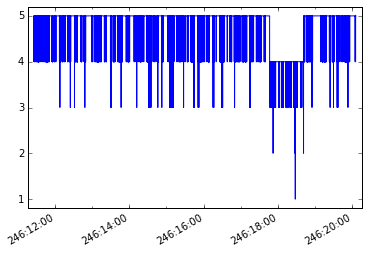

In [78]:
pd['AOKALSTR'].plot()

To calculate an "independent" estimate of the number of Kalman stars, I use values for the error flags, the fid status indicator, and the track status indicator, and star residual values.

In [79]:
telem = pd
dwell = d
# Track status                                                                                                
fids = np.column_stack([(telem['AOACFID{}'.format(slot)].vals == 'FID ')
                        for slot in range(0, 8)])
trak = np.column_stack([(telem['AOACFCT{}'.format(slot)].vals == 'TRAK')
    for slot in range(0, 8)])
# use rolled-by-4 for ~last 4.1 sample                                                                        
last_trak = np.roll(trak, 4, axis=0)
last_trak[0] = True

# Flags                                                                                                       
ir =  np.column_stack([(telem['AOACIIR{}'.format(slot)].vals == 'OK ')
                              for slot in range(0, 8)])
sp =  np.column_stack([(telem['AOACISP{}'.format(slot)].vals == 'OK ')
                               for slot in range(0, 8)])
dp_date = DateTime('2013:297:11:25:52.000').secs
dp =  np.column_stack([((telem['AOACIDP{}'.format(slot)].vals == 'OK ')
                                | (telem['AOKALSTR'].times > dp_date))
                               for slot in range(0, 8)])
if dwell.start > '2015:251':
    # I'm not sure about the fetch grid if we use fetch interpolate, so just use                              
    # a sorted search to see if the MSS flag should apply                                                     
    mss = telem['AOACIMSS'].vals == 'ENAB'
    mss_times = telem['AOACIMSS'].times
    mss_at_times = mss[np.searchsorted(mss_times[1:-1], telem['AOACIMS0'].times) -1]
    ms =  np.column_stack([((telem['AOACIMS{}'.format(slot)].vals == 'OK ')
                                   | ~mss_at_times)
                                   for slot in range(0, 8)])
else:
    ms =  np.column_stack([(telem['AOACIMS{}'.format(slot)].vals == 'OK ')
                            for slot in range(0, 8)])


This independent estimate uses the onboard threshold on the offsets of 20 arcsecs

In [80]:
redo_kal = np.sum(~fids & trak & last_trak & ir & sp & dp & ms
                           & (np.abs(yag_offs) < 20) & (np.abs(zag_offs) < 20),
                           axis=1)


In [81]:
kalstr = telem['AOKALSTR'].vals.astype(int)

And a look at the differences between this independently derived estimate of the number of stars in the filter
and the reported value of the stars available to the filter shows that the independent estimate is very good.

In [82]:
print np.count_nonzero(redo_kal - kalstr)
print 1.0 * np.count_nonzero(redo_kal - kalstr) / len(kalstr)


4
0.000131250820318


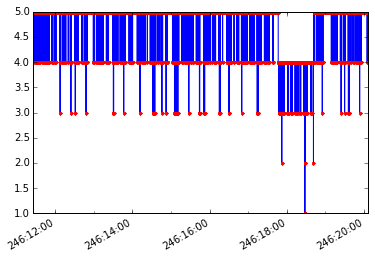

In [83]:
plot_cxctime(telem['AOKALSTR'].times, kalstr, 'b')
plot_cxctime(telem['AOKALSTR'].times, redo_kal, 'r.');

Extending the independent estimate, we estimate the count of Kalman stars if the residual threshold had been
set at 5 arcsecs in Y and Z instead of 20.

In [84]:
new_kal = np.sum(~fids & trak & last_trak & ir & sp & dp & ms
                           & (np.abs(yag_offs) < 5) & (np.abs(zag_offs) < 5),
                           axis=1)


For obsid 19697, with really no residuals between 5 and 20 arcsecs, the change in threshold shows no real effect on the espected Kalman stars.

(((matplotlib.dates.HourLocator,
   {'byhour': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]},
   '%j:%H:00',
   matplotlib.dates.HourLocator,
   {}),),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0bf5831050>)

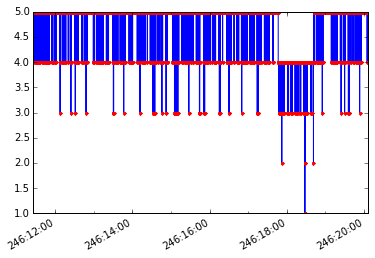

In [85]:
plot_cxctime(telem['AOKALSTR'].times, kalstr, 'b')
plot_cxctime(telem['AOKALSTR'].times, new_kal, 'r.')

We then evaluate the estimated Kalman stars with an observation that has known residuals between 5 and 20 arcsecs.

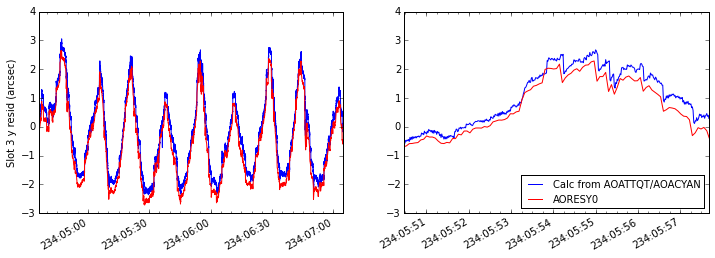

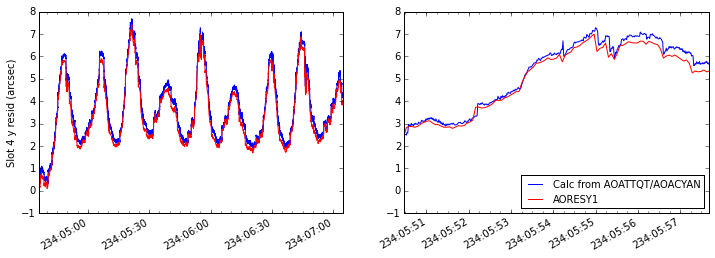

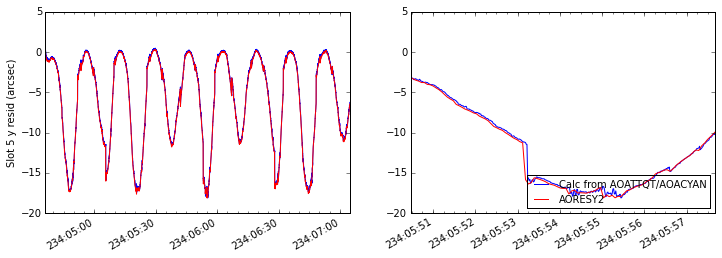

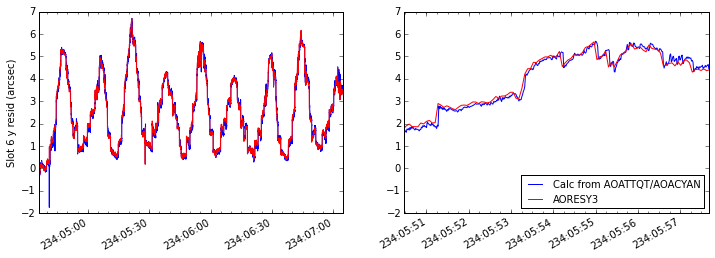

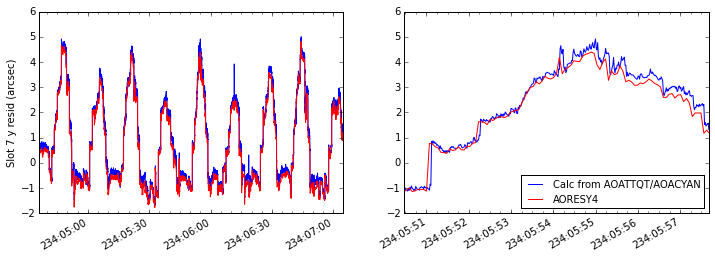

In [90]:
obsid = 18446
sc = mica.starcheck.get_starcheck_catalog(obsid)
catalog = Table(sc['cat'])
obs_dwells = events.dwells.filter(obsid=obsid)
d = obs_dwells[0]
if d.start < '2015:251':
    pcad_data = fetch.Msidset(msids + res_msids + slot_msids, d.start, d.stop)
else:
    pcad_data = fetch.Msidset(msids + res_msids + slot_msids + ['AOACIMSS'], d.start, d.stop)
# copy these to better names                                                                                            
for slot in [1, 2, 5, 6]:
    pcad_data['AORESY{}'.format(slot)] = pcad_data['AORESY{}_1'.format(slot)]
    pcad_data['AORESZ{}'.format(slot)] = pcad_data['AORESZ{}_1'.format(slot)]
q_atts = mica.quaternion.Quat(mica.quaternion.normalize(np.column_stack([pcad_data['AOATTQT1'].vals,
                                        pcad_data['AOATTQT2'].vals,
                                        pcad_data['AOATTQT3'].vals,
                                        pcad_data['AOATTQT4'].vals])))
expected_pos = {}
resids = {}
yag_offs = np.zeros((len(pcad_data['AOKALSTR'].vals), 8))
zag_offs = np.zeros((len(pcad_data['AOKALSTR'].vals), 8))
for entry in catalog[(catalog['type'] == 'BOT') | (catalog['type'] == 'GUI')]:
    slot = entry['slot']
    star = agasc.get_star(entry['id'], date=d.manvr.start)
    eci = radec2eci(star['RA_PMCORR'], star['DEC_PMCORR'])
    d_aca = np.dot(q_atts.transform.transpose(0,2,1), eci)
    yag = np.degrees(np.arctan2(d_aca[:, 1], d_aca[:, 0])) * 3600
    zag = np.degrees(np.arctan2(d_aca[:, 2], d_aca[:, 0])) * 3600
    yag_offs[:, slot] = yag - pcad_data['AOACYAN{}'.format(entry['slot'])].vals
    zag_offs[:, slot] = zag - pcad_data['AOACZAN{}'.format(entry['slot'])].vals
    expected_pos[slot] = {'yag': yag, 'zag': zag}
pd = pcad_data   
# these slots should work for most ORs
for slot, pos in zip([3, 4, 5, 6, 7],[0, 1, 2, 3, 4]):
    if slot not in expected_pos:
        continue
    fig, axes = subplots(1, 2, figsize=(12, 4))
    aoacyan = pd['AOACYAN{}'.format(slot)]
    ok = pd['AOACFCT{}'.format(slot)].vals == 'TRAK'
    axes[0].set_ylabel("Slot {} y resid (arcsec)".format(slot))
    plot_cxctime(aoacyan.times[ok], aoacyan.vals[ok] - expected_pos[slot]['yag'][ok], 'b', ax=axes[0]);
    plot_cxctime(pd['AORESY{}'.format(pos)].times, np.degrees(pd['AORESY{}'.format(pos)].vals) * 3600, 'r', ax=axes[0]);
    grid()
    plot_cxctime(aoacyan.times[ok], aoacyan.vals[ok] - expected_pos[slot]['yag'][ok], 'b', ax=axes[1],
                label='Calc from AOATTQT/AOACYAN');
    plot_cxctime(pd['AORESY{}'.format(pos)].times, np.degrees(pd['AORESY{}'.format(pos)].vals) * 3600, 'r', ax=axes[1],
                label='AORESY{}'.format(pos));
    grid()
    legend(loc='lower right', fontsize=10)
    xlims = xlim()
    # I should come back to this and use the plotdate things to get a zoom on the hot pix region
    xlim(np.mean(xlims), np.mean(xlims)+.005);
pd = pcad_data
telem = pd
dwell = d
# Track status                                                                                                
fids = np.column_stack([(telem['AOACFID{}'.format(slot)].vals == 'FID ')
                        for slot in range(0, 8)])
trak = np.column_stack([(telem['AOACFCT{}'.format(slot)].vals == 'TRAK')
    for slot in range(0, 8)])
# use rolled-by-4 for ~last 4.1 sample                                                                        
last_trak = np.roll(trak, 4, axis=0)
last_trak[0] = True

# Flags                                                                                                       
ir =  np.column_stack([(telem['AOACIIR{}'.format(slot)].vals == 'OK ')
                              for slot in range(0, 8)])
sp =  np.column_stack([(telem['AOACISP{}'.format(slot)].vals == 'OK ')
                               for slot in range(0, 8)])
dp_date = DateTime('2013:297:11:25:52.000').secs
dp =  np.column_stack([((telem['AOACIDP{}'.format(slot)].vals == 'OK ')
                                | (telem['AOKALSTR'].times > dp_date))
                               for slot in range(0, 8)])
if dwell.start > '2015:251':
    # I'm not sure about the fetch grid if we use fetch interpolate, so just use                              
    # a sorted search to see if the MSS flag should apply                                                     
    mss = telem['AOACIMSS'].vals == 'ENAB'
    mss_times = telem['AOACIMSS'].times
    mss_at_times = mss[np.searchsorted(mss_times[1:-1], telem['AOACIMS0'].times) -1]
    ms =  np.column_stack([((telem['AOACIMS{}'.format(slot)].vals == 'OK ')
                                   | ~mss_at_times)
                                   for slot in range(0, 8)])
else:
    ms =  np.column_stack([(telem['AOACIMS{}'.format(slot)].vals == 'OK ')
                            for slot in range(0, 8)])
kalstr = telem['AOKALSTR'].vals.astype(int)
new_kal = np.sum(~fids & trak & last_trak & ir & sp & dp & ms
                           & (np.abs(yag_offs) < 5) & (np.abs(zag_offs) < 5),
                           axis=1)

As expected, the use of the more restrictive limit on residuals would reduce the number of Kalman stars in this case, based solely on the observed telemetry.

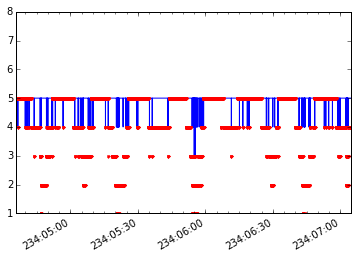

In [91]:
plot_cxctime(telem['AOKALSTR'].times, kalstr, 'b')
plot_cxctime(telem['AOKALSTR'].times, new_kal, 'r.');

I suspect that in practice, if the hot pixel in slot 5 had been excluded for more of the observation, the onboard solution and other star residuals would have been perturbed less by it, and the other star residuals would not be as large.  Even in obsid 18446, with 2 of the non-hot-pixel slots showing residuals exceeding 5 arcsecs, the number of consecutive samples with fewer than 2 Kalman stars never exceeds two samples.

In [92]:
def consecutive(data, stepsize=1):
        return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)
consecutive(np.flatnonzero(new_kal < 2))

[array([643, 644]),
 array([647, 648]),
 array([2609, 2610]),
 array([2613, 2614]),
 array([2625, 2626]),
 array([2669, 2670]),
 array([4569, 4570]),
 array([4588]),
 array([4601, 4602]),
 array([4605, 4606]),
 array([4609, 4610]),
 array([4613, 4614]),
 array([4617, 4618]),
 array([4621]),
 array([4631, 4632]),
 array([4654]),
 array([4661, 4662]),
 array([4689, 4690]),
 array([7438]),
 array([7449, 7450]),
 array([7503])]